In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch.autograd import Variable

from tqdm.notebook import tqdm

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### Use the MNIST dataset for all the experiments.

In [2]:
dataset = MNIST('data', train=True, download=True, transform=ToTensor())
test_dataset = MNIST('data', train=False, transform=ToTensor())

#### Use a 70:30 data split.

In [3]:
train_size = int(len(dataset) * 0.70)
val_size = len(dataset) - train_size

In [4]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [5]:
batch_size=128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)
test_loader = DataLoader(test_dataset, batch_size)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Evaluation Method

In [7]:
def evaluate(model, data_lodr, weights_path="q2.pth"):
    
    # prework
    model.to(device)

    criterion = nn.MSELoss().to(device)
    model.load_state_dict(torch.load(weights_path))

    # Evaluation
    running_loss = 0.0
    
    for i, data in enumerate(data_lodr, 0):
        inputs = Variable(data[0].view(-1, 28 * 28)).to(device)

        with torch.no_grad():
            outputs = model(inputs)
        loss = criterion(outputs, inputs)

        running_loss += loss.item()
    return (running_loss/len(data_lodr))


### Training method

In [8]:
def train(model, optimizer, train_lodr, val_lodr, epochs=20, weights_path="q2.pth", transfer_learning=False, save_weights=True):

    # Prework
    model.to(device)
    criterion = nn.MSELoss().to(device)

    if transfer_learning == True:
        model.load_state_dict(torch.load(weights_path))

    # Training
    # print("Trainning Started...")

    train_loss = []
    val_loss = []

    for epoch in tqdm(range(epochs)):

        # print("Epoch["+str(epoch)+"]:")

        # Training work
        train_running_loss = 0.0
        for i, data in enumerate(train_lodr, 0):
            
            inputs = Variable(data[0].view(-1, 28 * 28)).to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

            train_running_loss += loss.item()
        
        train_loss.append(train_running_loss/ len(train_lodr))

        # Validation work
        val_running_loss = 0.0
        for i, data in enumerate(val_lodr, 0):
            
            inputs = Variable(data[0].view(-1, 28 * 28)).to(device)

            with torch.no_grad():
                outputs = model(inputs)   
            loss = criterion(outputs, inputs)
            val_running_loss += loss.item()
        
        val_loss.append(val_running_loss/ len(val_lodr))

        # print("\tTrain-Loss: "+str(train_loss[-1]))
        # print("\tVal-Loss:   "+str(val_loss[-1]))

    # print("Trainning Ended...")

    # post Work
    if save_weights == True:
        torch.save(model.state_dict(), weights_path)

    return train_loss, val_loss

### Plot

In [9]:
epochs = 20
def plotlossgraph(x, y1, y2, title='Q1'):
    plt.plot(x, y1, 'g', label='Training loss')
    plt.plot(x, y2, 'b', label='validation loss')

    plt.title(title+' Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.legend()
    plt.show()

xepoch = range(1,epochs+1)

# Question 
## Bottleneck - 128

In [10]:
class Q128Net(nn.Module):
    def __init__(self):
        super(Q128Net, self).__init__()

        self.encode = nn.Sequential(
            nn.Linear(in_features=784, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU()
        )

        self.decode = nn.Sequential(
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=784),
            nn.ReLU()
        )

    def forward(self, x, action="all"):
        if action=="all":
            x = self.encode(x)
            x = self.decode(x)
        elif action=="encode":
            x = self.encode(x)
        elif action=="decode":
            x = self.decode(x)
        else:
            raise NotImplementedError
        return x

q128net = Q128Net()
q128net


Q128Net(
  (encode): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (decode): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): ReLU()
  )
)

### Adam

In [11]:
q128net = Q128Net()
q128_adam_optimizer = optim.Adam(q128net.parameters(), lr=0.001)

q128_adam_train_loss, q128_adam_val_loss = train(q128net, q128_adam_optimizer, train_loader, val_loader, epochs=20, weights_path="q2_128_adam.pth", transfer_learning=False, save_weights=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [12]:
q128_adam_loss = evaluate(q128net, test_loader, weights_path="q2_128_adam.pth")
q128_adam_loss

0.008771137016106255

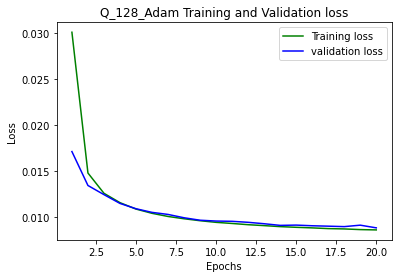

In [13]:
plotlossgraph(xepoch, q128_adam_train_loss, q128_adam_val_loss, title='Q_128_Adam')

### RMSProp

In [14]:
q128net = Q128Net()
q128_RMSProp_optimizer = optim.RMSprop(q128net.parameters(), lr=0.001, alpha=0.9)

q128_RMSProp_train_loss, q128_RMSProp_val_loss = train(q128net, q128_RMSProp_optimizer, train_loader, val_loader, epochs=20, weights_path="q2_128_RMSProp.pth", transfer_learning=False, save_weights=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [15]:
q128_RMSProp_loss = evaluate(q128net, test_loader, weights_path="q2_128_RMSProp.pth")
q128_RMSProp_loss

0.014287354648584806

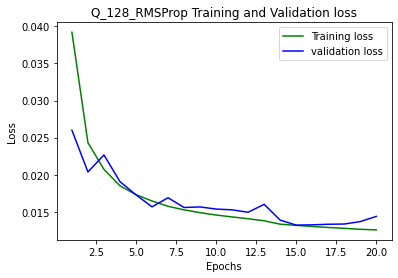

In [16]:
plotlossgraph(xepoch, q128_RMSProp_train_loss, q128_RMSProp_val_loss, title='Q_128_RMSProp')

### SGD with momentom

In [17]:
q128net = Q128Net()
q128_SGD_optimizer = optim.SGD(q128net.parameters(), lr=0.001, momentum=0.9)

q128_SGD_train_loss, q128_SGD_val_loss = train(q128net, q128_SGD_optimizer, train_loader, val_loader, epochs=20, weights_path="q2_128_SGD.pth", transfer_learning=False, save_weights=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [18]:
q128_SGD_loss = evaluate(q128net, test_loader, weights_path="q2_128_SGD.pth")
q128_SGD_loss

0.080571427092522

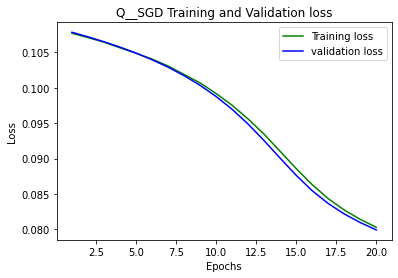

In [19]:
plotlossgraph(xepoch, q128_SGD_train_loss, q128_SGD_val_loss, title='Q__SGD')

### SGD Without momentom

In [20]:
q128net = Q128Net()
q128_SGD2_optimizer = optim.SGD(q128net.parameters(), lr=0.001)

q128_SGD2_train_loss, q128_SGD2_val_loss = train(q128net, q128_SGD2_optimizer, train_loader, val_loader, epochs=20, weights_path="q2_128_SGD2.pth", transfer_learning=False, save_weights=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [21]:
q128_SGD2_loss = evaluate(q128net, test_loader, weights_path="q2_128_SGD2.pth")
q128_SGD2_loss

0.10914858826730825

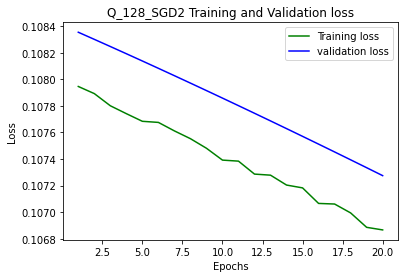

In [22]:
plotlossgraph(xepoch, q128_SGD2_train_loss, q128_SGD2_val_loss, title='Q_128_SGD2')

# Question 
## Bottleneck - 64

In [23]:
class Q64Net(nn.Module):
    def __init__(self):
        super(Q64Net, self).__init__()

        self.encode = nn.Sequential(
            nn.Linear(in_features=784, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=64),
            nn.ReLU()
        )

        self.decode = nn.Sequential(
            nn.Linear(in_features=64, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=784),
            nn.ReLU()
        )

    def forward(self, x, action="all"):
        if action=="all":
            x = self.encode(x)
            x = self.decode(x)
        elif action=="encode":
            x = self.encode(x)
        elif action=="decode":
            x = self.decode(x)
        else:
            raise NotImplementedError
        return x

q64net = Q64Net()
q64net


Q64Net(
  (encode): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
  )
  (decode): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): ReLU()
  )
)

### Adam

In [24]:
q64net = Q64Net()
q64_adam_optimizer = optim.Adam(q64net.parameters(), lr=0.001)

q64_adam_train_loss, q64_adam_val_loss = train(q64net, q64_adam_optimizer, train_loader, val_loader, epochs=20, weights_path="q2_64_adam.pth", transfer_learning=False, save_weights=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [25]:
q64_adam_loss = evaluate(q64net, test_loader, weights_path="q2_64_adam.pth")
q64_adam_loss

0.01287715681651725

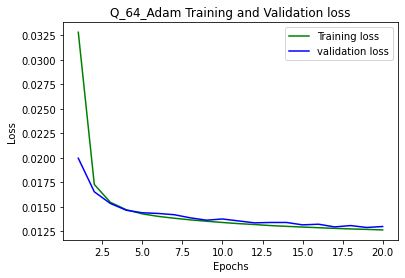

In [26]:
plotlossgraph(xepoch, q64_adam_train_loss, q64_adam_val_loss, title='Q_64_Adam')

### RMSProp

In [27]:
q64net = Q64Net()
q64_RMSProp_optimizer = optim.RMSprop(q64net.parameters(), lr=0.001, alpha=0.9)

q64_RMSProp_train_loss, q64_RMSProp_val_loss = train(q64net, q64_RMSProp_optimizer, train_loader, val_loader, epochs=20, weights_path="q2_64_RMSProp.pth", transfer_learning=False, save_weights=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [28]:
q64_RMSProp_loss = evaluate(q64net, test_loader, weights_path="q2_64_RMSProp.pth")
q64_RMSProp_loss

0.012498942274553112

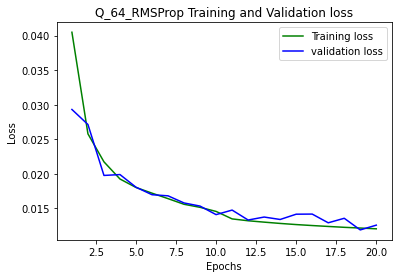

In [29]:
plotlossgraph(xepoch, q64_RMSProp_train_loss, q64_RMSProp_val_loss, title='Q_64_RMSProp')

### SGD with momentom

In [30]:
q64net = Q64Net()
q64_SGD_optimizer = optim.SGD(q64net.parameters(), lr=0.001, momentum=0.9)

q64_SGD_train_loss, q64_SGD_val_loss = train(q64net, q64_SGD_optimizer, train_loader, val_loader, epochs=20, weights_path="q2_64_SGD.pth", transfer_learning=False, save_weights=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [31]:
q64_SGD_loss = evaluate(q64net, test_loader, weights_path="q2_64_SGD.pth")
q64_SGD_loss

0.0841435736304597

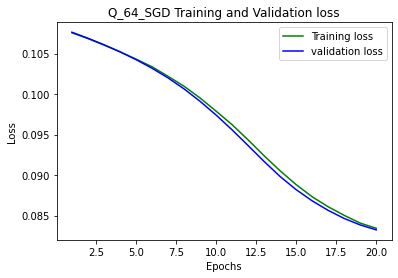

In [32]:
plotlossgraph(xepoch, q64_SGD_train_loss, q64_SGD_val_loss, title='Q_64_SGD')

### SGD Without momentom

In [33]:
q64net = Q64Net()
q64_SGD2_optimizer = optim.SGD(q64net.parameters(), lr=0.001)

q64_SGD2_train_loss, q64_SGD2_val_loss = train(q64net, q64_SGD2_optimizer, train_loader, val_loader, epochs=20, weights_path="q2_64_SGD2.pth", transfer_learning=False, save_weights=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [34]:
q64_SGD2_loss = evaluate(q64net, test_loader, weights_path="q2_64_SGD2.pth")
q64_SGD2_loss

0.10883363025097907

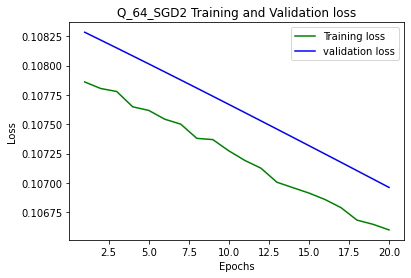

In [35]:
plotlossgraph(xepoch, q64_SGD2_train_loss, q64_SGD2_val_loss, title='Q_64_SGD2')

# Question 
## Bottleneck - 32

In [36]:
class Q32Net(nn.Module):
    def __init__(self):
        super(Q32Net, self).__init__()

        self.encode = nn.Sequential(
            nn.Linear(in_features=784, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=32),
            nn.ReLU()
        )

        self.decode = nn.Sequential(
            nn.Linear(in_features=32, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=784),
            nn.ReLU()
        )

    def forward(self, x, action="all"):
        if action=="all":
            x = self.encode(x)
            x = self.decode(x)
        elif action=="encode":
            x = self.encode(x)
        elif action=="decode":
            x = self.decode(x)
        else:
            raise NotImplementedError
        return x

q32net = Q32Net()
q32net


Q32Net(
  (encode): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=32, bias=True)
    (3): ReLU()
  )
  (decode): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): ReLU()
  )
)

### Adam

In [37]:
q32net = Q32Net()
q32_adam_optimizer = optim.Adam(q32net.parameters(), lr=0.001)

q32_adam_train_loss, q32_adam_val_loss = train(q32net, q32_adam_optimizer, train_loader, val_loader, epochs=20, weights_path="q2_32_adam.pth", transfer_learning=False, save_weights=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [38]:
q32_adam_loss = evaluate(q32net, test_loader, weights_path="q2_32_adam.pth")
q32_adam_loss

0.013333874106218543

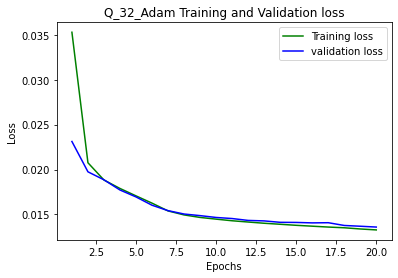

In [39]:
plotlossgraph(xepoch, q32_adam_train_loss, q32_adam_val_loss, title='Q_32_Adam')

### RMSProp

In [40]:
q32net = Q32Net()
q32_RMSProp_optimizer = optim.RMSprop(q32net.parameters(), lr=0.001, alpha=0.9)

q32_RMSProp_train_loss, q32_RMSProp_val_loss = train(q32net, q32_RMSProp_optimizer, train_loader, val_loader, epochs=20, weights_path="q2_32_RMSProp.pth", transfer_learning=False, save_weights=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [41]:
q32_RMSProp_loss = evaluate(q32net, test_loader, weights_path="q2_32_RMSProp.pth")
q32_RMSProp_loss

0.012542899084996574

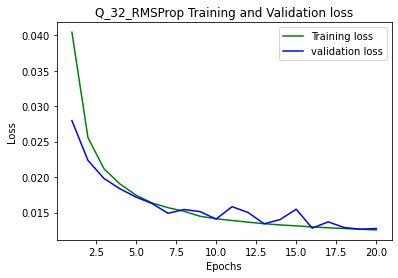

In [42]:
plotlossgraph(xepoch, q32_RMSProp_train_loss, q32_RMSProp_val_loss, title='Q_32_RMSProp')

### SGD with momentom

In [43]:
q32net = Q32Net()
q32_SGD_optimizer = optim.SGD(q32net.parameters(), lr=0.001, momentum=0.9)

q32_SGD_train_loss, q32_SGD_val_loss = train(q32net, q32_SGD_optimizer, train_loader, val_loader, epochs=20, weights_path="q2_32_SGD.pth", transfer_learning=False, save_weights=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [44]:
q32_SGD_loss = evaluate(q32net, test_loader, weights_path="q2_32_SGD.pth")
q32_SGD_loss

0.08617703550601308

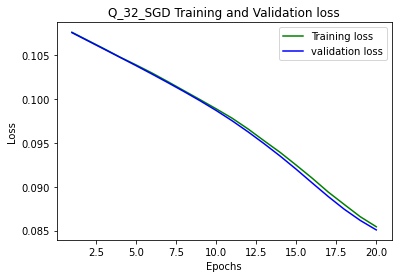

In [45]:
plotlossgraph(xepoch, q32_SGD_train_loss, q32_SGD_val_loss, title='Q_32_SGD')

### SGD Without momentom

In [46]:
q32net = Q32Net()
q32_SGD2_optimizer = optim.SGD(q32net.parameters(), lr=0.001)

q32_SGD2_train_loss, q32_SGD2_val_loss = train(q32net, q32_SGD2_optimizer, train_loader, val_loader, epochs=20, weights_path="q2_32_SGD2.pth", transfer_learning=False, save_weights=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [47]:
q32_SGD2_loss = evaluate(q32net, test_loader, weights_path="q2_32_SGD2.pth")
q32_SGD2_loss

0.1084180522379996

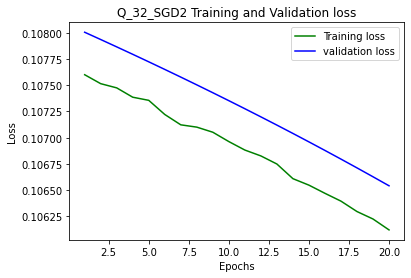

In [48]:
plotlossgraph(xepoch, q32_SGD2_train_loss, q32_SGD2_val_loss, title='Q_32_SGD2')

# Question 
## Bottleneck - 16

In [49]:
class Q16Net(nn.Module):
    def __init__(self):
        super(Q16Net, self).__init__()

        self.encode = nn.Sequential(
            nn.Linear(in_features=784, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=16),
            nn.ReLU()
        )

        self.decode = nn.Sequential(
            nn.Linear(in_features=16, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=784),
            nn.ReLU()
        )

    def forward(self, x, action="all"):
        if action=="all":
            x = self.encode(x)
            x = self.decode(x)
        elif action=="encode":
            x = self.encode(x)
        elif action=="decode":
            x = self.decode(x)
        else:
            raise NotImplementedError
        return x

q16net = Q16Net()
q16net


Q16Net(
  (encode): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=16, bias=True)
    (3): ReLU()
  )
  (decode): Sequential(
    (0): Linear(in_features=16, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): ReLU()
  )
)

### Adam

In [50]:
q16net = Q16Net()
q16_adam_optimizer = optim.Adam(q16net.parameters(), lr=0.001)

q16_adam_train_loss, q16_adam_val_loss = train(q16net, q16_adam_optimizer, train_loader, val_loader, epochs=20, weights_path="q2_16_adam.pth", transfer_learning=False, save_weights=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [51]:
q16_adam_loss = evaluate(q16net, test_loader, weights_path="q2_16_adam.pth")
q16_adam_loss

0.021960057931233058

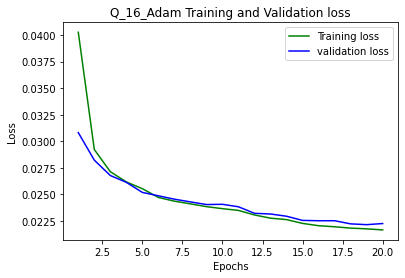

In [52]:
plotlossgraph(xepoch, q16_adam_train_loss, q16_adam_val_loss, title='Q_16_Adam')

### RMSProp

In [53]:
q16net = Q16Net()
q16_RMSProp_optimizer = optim.RMSprop(q16net.parameters(), lr=0.001, alpha=0.9)

q16_RMSProp_train_loss, q16_RMSProp_val_loss = train(q16net, q16_RMSProp_optimizer, train_loader, val_loader, epochs=20, weights_path="q2_16_RMSProp.pth", transfer_learning=False, save_weights=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [54]:
q16_RMSProp_loss = evaluate(q16net, test_loader, weights_path="q2_16_RMSProp.pth")
q16_RMSProp_loss

0.0171977690291367

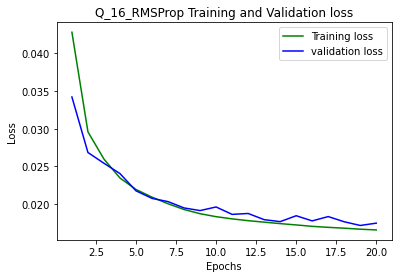

In [55]:
plotlossgraph(xepoch, q16_RMSProp_train_loss, q16_RMSProp_val_loss, title='Q_16_RMSProp')

### SGD with momentom

In [56]:
q16net = Q16Net()
q16_SGD_optimizer = optim.SGD(q16net.parameters(), lr=0.001, momentum=0.9)

q16_SGD_train_loss, q16_SGD_val_loss = train(q16net, q16_SGD_optimizer, train_loader, val_loader, epochs=20, weights_path="q2_16_SGD.pth", transfer_learning=False, save_weights=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [57]:
q16_SGD_loss = evaluate(q16net, test_loader, weights_path="q2_16_SGD.pth")
q16_SGD_loss

0.08237106390768968

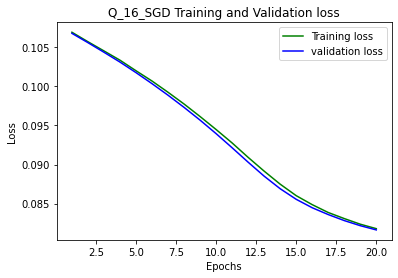

In [58]:
plotlossgraph(xepoch, q16_SGD_train_loss, q16_SGD_val_loss, title='Q_16_SGD')

### SGD Without momentom

In [59]:
q16net = Q16Net()
q16_SGD2_optimizer = optim.SGD(q16net.parameters(), lr=0.001)

q16_SGD2_train_loss, q16_SGD2_val_loss = train(q16net, q16_SGD2_optimizer, train_loader, val_loader, epochs=20, weights_path="q2_16_SGD2.pth", transfer_learning=False, save_weights=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [60]:
q16_SGD2_loss = evaluate(q16net, test_loader, weights_path="q2_16_SGD2.pth")
q16_SGD2_loss

0.10779018417189393

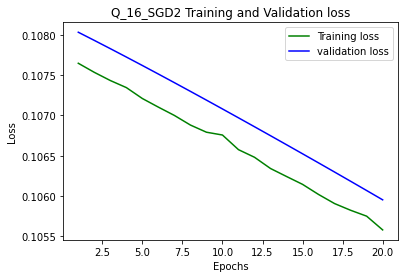

In [61]:
plotlossgraph(xepoch, q16_SGD2_train_loss, q16_SGD2_val_loss, title='Q_16_SGD2')

## Plot the test reconstruction loss vs hidden neurons for all the above optimizers.

In [62]:
def plotpoints(x, y, title=""):
    plt.plot(x, y, 'o', label='Testing loss')

    plt.title(title+' Testing loss')
    plt.xlabel('Bottle Neck Neurons')
    plt.ylabel('Loss')

    plt.legend()
    plt.show()

xpoints = [16,32,64,128]

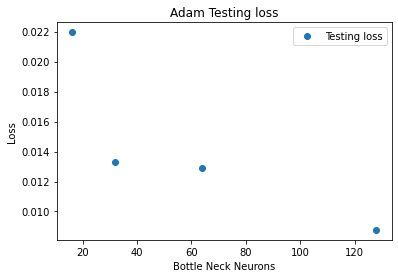

In [63]:
plotpoints(xpoints, [q16_adam_loss, q32_adam_loss, q64_adam_loss, q128_adam_loss], title="Adam")

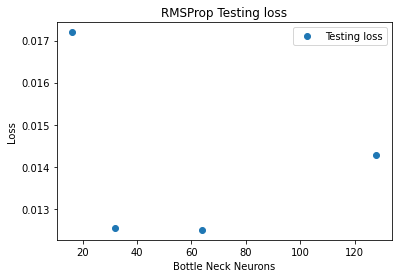

In [64]:
plotpoints(xpoints, [q16_RMSProp_loss, q32_RMSProp_loss, q64_RMSProp_loss, q128_RMSProp_loss], title="RMSProp")


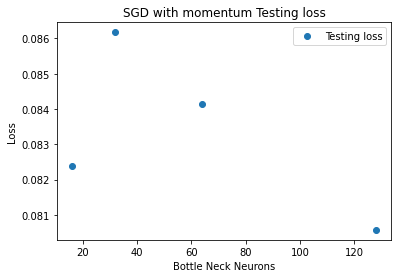

In [65]:
plotpoints(xpoints, [q16_SGD_loss, q32_SGD_loss, q64_SGD_loss, q128_SGD_loss], title="SGD with momentum")


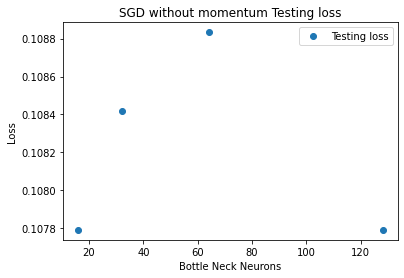

In [66]:
plotpoints(xpoints, [q16_SGD2_loss, q32_SGD2_loss, q64_SGD2_loss, q16_SGD2_loss], title="SGD without momentum")


## Perform PCA reconstruction and compare with the Autoencoder reconstruction using test reconstruction loss (you can use inbuilt PCA).

In [67]:
from sklearn.decomposition import PCA
import keras 
from  keras.datasets import mnist
import numpy as NP

(X_TRAIN,Y_TRAIN),(X_TEST,Y_TEST) = mnist.load_data()
X_TRAIN = NP.reshape(X_TRAIN,(60000,784))
X_TEST = NP.reshape(X_TEST,(10000,784))
X_TRAIN = X_TRAIN/255
X_TEST = X_TEST/255

pca = PCA(128)
pca.fit(X_TRAIN)
TRAIN= pca.transform(X_TRAIN)
TEST = pca.transform(X_TEST)
approximation = pca.inverse_transform(TEST)

In [68]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(X_TEST, approximation)

0.0354346358053794

# Analysis

- PCA is essentially a linear transformation but Auto-encoders are capable of modelling complex non linear functions.
- PCA is faster and computationally cheaper than autoencoders
- So, PCA is facter but autoencoder has capability to modelling complex non linear functions so it can give better results where non linear corelation is needed on the data